```[Lorenzo]```  
This is a test of using LSTM classifying the spam emails!!!!   
First, transform the data into numerical form!

In [1]:
## first get the data!
# !wget http://lazyprogrammer.me/course_files/spam.csv

In [2]:
import torch;
import torch.nn as nn;
import torchtext.data as ttd;
from torchtext.vocab import GloVe;

import numpy as np;
import matplotlib.pyplot as plt;
import pandas as pd;
from datetime import datetime;

In [3]:
df = pd.read_csv('C://Yizhou_coding//Coursework//2020 SP course//CS 760//Project//GitHub//0_group work//datset//spam.csv', encoding = "ISO-8859-1");
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1);
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.columns = ['labels', 'data'];
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
## create binary labels
df['binary_labels'] = df['labels'].map({'ham': 0, 'spam':1});
df.head()

,labels,data,binary_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [7]:
## create new data frame
#df2 = df[['data','binary_labels']];
df2 = df[df.columns[1:3]];
df2.head()

,data,binary_labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [8]:
df2.to_csv('spam2.csv', index = False);

In [9]:
## implement the object
TEXT = ttd.Field(
    sequential = True,
    batch_first = True,
    lower = True,
    #tokenize = 'spacy',
    pad_first = True
)
LABEL = ttd.Field(sequential = False, use_vocab = False, is_target = True);
dataset = ttd.TabularDataset(path = 'spam2.csv', format = 'csv',
                             skip_header = True,
                             fields = [('data', TEXT),('label', LABEL)] 
                             ## it will generate an obj dattset.example.data
                             ## and an obj dattset.example.label
                             );

train_dataset, test_dataset = dataset.split(0.85);## default 0.7 here
TEXT.build_vocab(train_dataset);
vocab = TEXT.vocab;
print(len(vocab))
#vocab.stoi
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu");
print(device);

12323
cpu


In [10]:
train_iter, test_iter = ttd.Iterator.splits(
    (train_dataset, test_dataset), 
    sort_key = lambda x: len(x.data), ## x is this object
    batch_sizes = (32,1000),
    device = device
    );
print(len(train_dataset));
print(len(test_dataset))
printlist = [0,1,2,3,4,10,20,30,40];
ind = 0;
for inputs, targets in train_iter:
    #print(inputs,'\n',targets);
    #break;
    if ind in printlist:
        print(ind, inputs.shape);
    ind += 1;
print(ind)

ind = 0;
for inputs, targets in test_iter:
    #print(inputs,'\n',targets);
    #break;
    if ind in printlist:
        print(ind, inputs.shape);
    ind += 1;
print(ind)

4736
836
0 torch.Size([32, 32])
1 torch.Size([32, 52])
2 torch.Size([32, 38])
3 torch.Size([32, 52])
4 torch.Size([32, 33])
10 torch.Size([32, 30])
20 torch.Size([32, 32])
30 torch.Size([32, 39])
40 torch.Size([32, 32])
148
0 torch.Size([836, 96])
1


```[Lorenzo]```  
# Build the RNN model!

In [11]:
class RNN(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs):
        super(RNN,self).__init__();
        self.V = n_vocab;
        self.D = embed_dim;
        self.M = n_hidden;
        self.K = n_outputs;
        self.L = n_rnnlayers;

        self.embed = nn.Embedding(self.V, self.D);
        self.rnn = nn.LSTM(
            input_size = self.D,
            hidden_size = self.M,
            num_layers = self.L,
            batch_first = True,
            dropout = 0.25
        );

        self.fc = nn.Linear(self.M,self.K);

    def forward(self, X):
        ## init hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device);
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device);

        ## embedding layer
        ## words index 2 into word vectors
        out = self.embed(X);

        ## get rnn unit output
        out,_ = self.rnn(out, (h0,c0));

        ## max pool
        out,_ = torch.max(out,1);
        ## we only need h(T) finally
        out = self.fc(out);
        return out;

import torch.nn.functional as F;
class CNN(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_outputs):
        super(CNN,self).__init__();
        self.V = n_vocab;
        self.D = embed_dim;
        self.K = n_outputs;

        ## dropout
        self.dropout = nn.Dropout(p = 0.25);

        ##layers implement
        self.embed = nn.Embedding(self.V, self.D);
        ## embed layer output is [N T D];

        self.conv1 = nn.Conv1d(self.D, 32, 3, padding=1);
        ## conv layer 1 output is [N T M];

        self.pool1 = nn.MaxPool1d(2);
        ## max pooling layer 1 output is [N T2 M]

        self.conv2 = nn.Conv1d(32, 64, 3, padding = 1);
        ## conv layer 2 output is  [N T2 M2]

        self.pool2 = nn.MaxPool1d(2);
        ## max pooling layer 2 output is [N T3 M2];

        self.conv3 = nn.Conv1d(64, 128,3, padding = 1);
        ## conv layer 3 output is [N T3 M3]

        # flattern / global max pool later 
        ## output [N M3]
        self.fc = nn.Linear(128, self.K);

        '''
        in Torch, features come first
        in TF/ NLP, features come last
        
        So Before and After Convolution layer, we HAVE to reshape! 
        '''
    def forward(self,X):
        ## input is [N T]
        # embed layer
        out = self.embed(X); ## output is [N T D]

        out = out.permute(0,2,1); ## out is [N D T], feature first
        out = self.conv1(out); ## out is [N M T]
        out = F.relu(out); ## [N M T]
        out = self.dropout(out);
        out = self.pool1(out); ## out is [N M T2];

        out = self.conv2(out); ## out is [N M2 T2]
        out = F.relu(out); ## [N M2 T2]
        out = self.dropout(out);
        out = self.pool2(out); ## out is [N M2 T3];

        out = self.conv3(out); ## [N M3 T3];
        out = self.dropout(out);

        out = out.permute(0,2,1); ## [N T3 M3];
        out,_ = torch.max(out,1); ## [N M3]; Global Max pool

        ## final dense layer
        return self.fc(out);


## This is RNN/LSTM or CNN model!

In [12]:
'''
expected output: 
RNN(
    (embed): Embedding(14274, 20)
    (rnn): LSTM(20,15, batch_first = True)
    (fc): Linear(in_features = 15, out_features = 1, bias = True)
);
'''
choice = 2;
if choice == 1:
    model = RNN(len(vocab), 20, 12,1,1 );
    model.to(device);
elif choice == 2:
    model = CNN(len(vocab), 20,1 );
    model.to(device);


In [13]:
## Loss and optimizer
criterion = nn.BCEWithLogitsLoss(); ## Python can even return a function
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3);

def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs, print_epoch = 20):
    train_losses = np.zeros(epochs);
    test_losses = np.zeros(epochs);

    for it in range(epochs):
        if it%print_epoch  == 0:
            t0 = datetime.now();
        
        train_loss = [];
        
        for inputs, targets in train_iter:
            targets = targets.view(-1,1).float();
            ## move data to GPU
            inputs, targets  =  inputs.to(device), targets.to(device);

            ## zero the parameter gradient
            optimizer.zero_grad();

            ## forward pass
            outputs = model(inputs);
            loss = criterion(outputs, targets);

            ## back probagation
            loss.backward();
            optimizer.step();
            train_loss.append(loss.item());

        train_loss = np.mean(train_loss);

        test_loss = [];
        for inputs, targets in test_iter:
            targets = targets.view(-1,1).float();
            ## move data to GPU
            ## inputs, targets  =  inputs.to(device), targets.to(device);

            ## zero the parameter gradient
            optimizer.zero_grad();

            ## forward pass,  no need to back
            outputs = model(inputs);
            loss = criterion(outputs, targets);
            test_loss.append(loss.item());
        
        test_loss = np.mean(test_loss);

        train_losses[it] = train_loss;
        test_losses[it] = test_loss;

        if it%print_epoch  == 0:
            dt = datetime.now() - t0;

            print("Epoch (%d / %d)...Train Loss: %.3e...Test_loss: %.3e...Duration: %s" 
                %(it, epochs, train_loss, test_loss, dt));


    return train_losses, test_losses;



In [14]:
RNN_epochs = 15;
CNN_epochs = 6;
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_iter, test_iter, CNN_epochs,1);

Epoch (0 / 6)...Train Loss: 3.505e-01...Test_loss: 3.186e-01...Duration: 0:00:03.672176
Epoch (1 / 6)...Train Loss: 2.106e-01...Test_loss: 1.680e-01...Duration: 0:00:03.635276
Epoch (2 / 6)...Train Loss: 1.431e-01...Test_loss: 1.619e-01...Duration: 0:00:03.966391
Epoch (3 / 6)...Train Loss: 1.078e-01...Test_loss: 1.099e-01...Duration: 0:00:03.702097
Epoch (4 / 6)...Train Loss: 8.904e-02...Test_loss: 1.071e-01...Duration: 0:00:03.754956
Epoch (5 / 6)...Train Loss: 6.818e-02...Test_loss: 8.679e-02...Duration: 0:00:04.140924


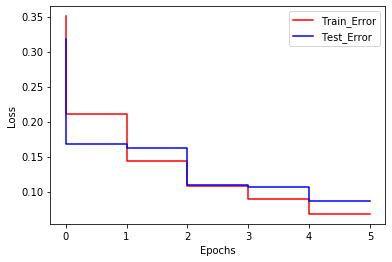

In [15]:
plt.figure();
plt.step(range(len(train_losses)),train_losses, c = 'r', label = 'Train_Error');
plt.step(range(len(test_losses)),test_losses, c = 'b', label  = 'Test_Error');
plt.legend();
plt.xlabel('Epochs');
plt.ylabel('Loss');
plt.show();

In [16]:
## Accuracy:
n_correct = 0.0;
n_total = 0.0;

for inputs, targets in train_iter:
    targets = targets.view(-1,1).float();
    outputs = model(inputs);
    prediction = (outputs > 0);

    n_total += targets.shape[0];
    n_correct += (targets == prediction).sum().item();

train_acc = n_correct/n_total;

n_correct = 0.0;
n_total = 0.0;
for inputs, targets in test_iter:
    targets = targets.view(-1,1).float();
    outputs = model(inputs);
    prediction = (outputs > 0);

    n_total += targets.shape[0];
    n_correct += (targets == prediction).sum().item();

test_acc = n_correct/n_total;

print("Training Accuracy = %.3e \nTesting Accuracy = %.3e" %(train_acc,
                                                             test_acc));
    

Training Accuracy = 9.865e-01 
Testing Accuracy = 9.713e-01


## This is CNN model!

Doing a classification with 2 label(s)!
Epoch (0 / 5)...Train Loss: 3.510e-01...Test_loss: 2.531e-01...Duration: 4.507940053939819
Epoch (1 / 5)...Train Loss: 2.032e-01...Test_loss: 1.722e-01...Duration: 8.711695671081543
Epoch (2 / 5)...Train Loss: 1.361e-01...Test_loss: 1.196e-01...Duration: 12.774827718734741
Epoch (3 / 5)...Train Loss: 1.018e-01...Test_loss: 1.094e-01...Duration: 16.756178617477417
Epoch (4 / 5)...Train Loss: 8.172e-02...Test_loss: 1.021e-01...Duration: 20.777422666549683


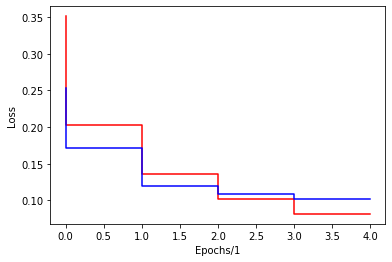

Training:
The classification rate for this dataset is 97.6%
Testing:
The classification rate for this dataset is 96.6%


In [17]:
import YZ_nn_training_format
from YZ_nn_training_format import YZ_torch_std;
K_class = 2;
model = CNN(len(vocab), 20, K_class);
STD = YZ_torch_std(model, device, train_iter, test_iter, K_class = K_class);
#STD.Optimizing(epochs = 5, plot_epoch = 1);
STD.Optimizing2(epochs = 5, plot_epoch = 1);

Doing a classification with 2 label(s)!

Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ | 20.0%
Epoch (1 / 5)...Train_Loss: 3.457e-01...Test_loss: 2.361e-01...Duration: 4.130e+00 sec
Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ | 40.0%
Epoch (2 / 5)...Train_Loss: 1.942e-01...Test_loss: 1.593e-01...Duration: 8.191e+00 sec
Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░░░░░░░░░░░ | 60.0%
Epoch (3 / 5)...Train_Loss: 1.367e-01...Test_loss: 1.441e-01...Duration: 1.223e+01 sec
Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒░░░░░░░░░░ | 80.0%
Epoch (4 / 5)...Train_Loss: 1.058e-01...Test_loss: 1.262e-01...Duration: 1.647e+01 sec
Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ | 100.0% (^_^)/ Done!
Epoch (5 / 5)...Train_Loss: 7.782e-02...Test_loss: 1.183e-01...Duration: 2.087e+01 sec
Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒

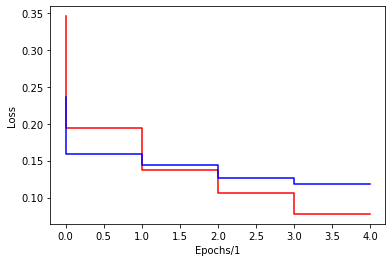

Training:
The classification rate for this dataset is 97.9%
Testing:
The classification rate for this dataset is 96.4%


In [18]:
import YZ_nn_training_format
from YZ_nn_training_format import YZ_torch_std;
K_class = 2;
model = CNN(len(vocab), 20, K_class);
STD = YZ_torch_std(model, device, train_iter, test_iter, K_class = K_class);
STD.Optimizing(epochs = 5, plot_epoch = 1);
#STD.Optimizing2(epochs = 5, plot_epoch = 1);

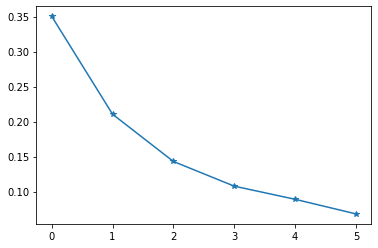

In [20]:
plt.plot(train_losses, marker ='*');